# Titanic Challenge

In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/titanic/test.csv
kaggle/input/titanic/titanic.zip
kaggle/input/titanic/train.csv
kaggle/input/titanic/gender_submission.csv


### Look for columns with missing values

In [57]:
t_train_orig = pd.read_csv("kaggle/input/titanic/train.csv")
t_train_orig.name = "Titanic Training Set"

t_test_orig = pd.read_csv("kaggle/input/titanic/test.csv")
t_test_orig.name = "Titanic Test Set"

def display_missing(df):    
    for col in df.columns.tolist(): 
        if df[col].isnull().sum() > 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

dfs = [t_train_orig, t_test_orig]


for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Titanic Training Set
Age column missing values: 177
Cabin column missing values: 687
Embarked column missing values: 2


Titanic Test Set
Age column missing values: 86
Fare column missing values: 1
Cabin column missing values: 327




###  women were much more likely to survive than men

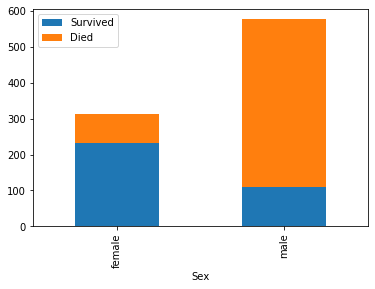

In [58]:
t_train_orig['Died']= t_train_orig['Survived'].map(lambda survived: 0 if survived == 1 else 1)
t_train_orig.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

### let's look at the correlation between ticket price and the likelihood of survival

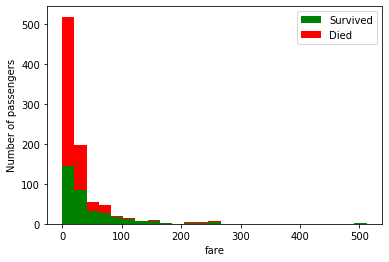

In [59]:
import matplotlib.pyplot as plt
t = t_train_orig
fare_survived =t[t['Survived'] == 1]['Fare'] 
fare_died = t[t['Survived'] == 0]['Fare'] 
plt.hist([fare_survived, fare_died], stacked=True, color = ['g', 'r'], 
         bins = 25, label=['Survived', 'Died'])
plt.xlabel('fare')
plt.ylabel('Number of passengers')
plt.legend()

### See what  Age is correlated with best
so we can fill in nulls with more representative values

In [60]:
t_train_corr = t_train_orig.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
t_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)

groups = t_train_corr[(0.1 < t_train_corr["Correlation Coefficient"]) & (t_train_corr["Correlation Coefficient"] < .85)].groupby('Feature 1')

groups.get_group('Survived')
    

,Feature 1,Feature 2,Correlation Coefficient
17,Survived,Pclass,0.338481
22,Survived,Fare,0.257307


In [61]:
groups.get_group('Age')

,Feature 1,Feature 2,Correlation Coefficient
15,Age,Pclass,0.369226
20,Age,SibSp,0.308247
28,Age,Parch,0.189119


### Sample training data

In [62]:
t_train_orig.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
586,587,0,2,"Jarvis, Mr. John Denzil",male,47.0,0,0,237565,15.0000,NaN,S,1
662,663,0,1,"Colley, Mr. Edward Pomeroy",male,47.0,0,0,5727,25.5875,E58,S,1
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,C,0
551,552,0,2,"Sharp, Mr. Percival James R",male,27.0,0,0,244358,26.0000,NaN,S,1
808,809,0,2,"Meyer, Mr. August",male,39.0,0,0,248723,13.0000,NaN,S,1
847,848,0,3,"Markoff, Mr. Marin",male,35.0,0,0,349213,7.8958,NaN,C,1
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,1
355,356,0,3,"Vanden Steen, Mr. Leo Peter",male,28.0,0,0,345783,9.5000,NaN,S,1
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,0
613,614,0,3,"Horgan, Mr. John",male,NaN,0,0,370377,7.7500,NaN,Q,1


## Feature exploration

Here are some initial ideas:
* Pclass (1 > 2 > 3)
* Fare ($$ > $)
* Sex (female > male)
* CabinPresent (1 > 0)
* Is child over 12 (1 > 0)


In [118]:
import math

t_train = t_train_orig

# sex to numeric
t_train['SexNumeric'] = np.where(t_train['Sex'] == "male", 0, 1)

# fill in missing fare with median fare for passengers in the same class
med_fares = t_train.groupby('Pclass')['Fare'].median()
def fare_for_class(row):
    return median_fares[row['Pclass']] if row['Fare'] == 0 else row['Fare']

t_train['FareAdjusted'] = t_train.apply(fare_for_class,axis=1)

# fill in missing age with get median age for passengers in the same class
med_ages = t_train.groupby('Pclass')['Age'].median()
def age_for_class(row):
    return median_ages[row['Pclass']] if np.isnan(row['Age']) else row['Age']

t_train['AgeAdjusted'] = t_train.apply(age_for_class,axis=1)

# extract titles
#get_index = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y][0]

t_train['Title'] = t_train_orig['Name'].map(lambda name: [title for title in name.split(' ') if '.' in title][0])
#all_titles = t_train['Title'].unique()
titles_esteemed_first = {
    'Countess.': 17,
    'Lady.': 16,
    'Rev.': 15,
    'Jonkheer.': 14,
    'Master.': 13,
    'Major.' : 12,
    'Don.': 11,
    'Dr.' : 10,
    'Col.': 9,
    'Capt.': 8,
    'Mlle.': 7,
    'Miss.': 6,
    'Ms.': 5,
    'Mrs.': 4,
    'Mme.': 3,
    'Sir.': 2,
    'Mr.': 1
}
t_train['TitleNumeric'] = t_train['Title'].map(lambda title: titles_esteemed_first[title])


feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']
t_train[feature_cols].sample(10)

,FareAdjusted,Pclass,SexNumeric,TitleNumeric
589,8.0500,3,0,1
35,52.0000,1,0,1
782,30.0000,1,0,1
790,7.7500,3,0,1
283,8.0500,3,0,1
342,13.0000,2,0,1
89,8.0500,3,0,1
358,7.8792,3,1,6
373,135.6333,1,0,1
507,26.5500,1,0,1


In [119]:
t_train_corr = t_train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
t_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)

groups = t_train_corr[(0.1 < t_train_corr["Correlation Coefficient"]) & (t_train_corr["Correlation Coefficient"] < .6)].groupby('Feature 1')
for feature in feature_cols:
    print(groups.get_group(feature))


       Feature 1     Feature 2  Correlation Coefficient
19  FareAdjusted        Pclass                 0.561243
58  FareAdjusted          Died                 0.250635
59  FareAdjusted      Survived                 0.250635
67  FareAdjusted         Parch                 0.212103
73  FareAdjusted    SexNumeric                 0.175647
78  FareAdjusted         SibSp                 0.155423
82  FareAdjusted   AgeAdjusted                 0.128871
88  FareAdjusted  TitleNumeric                 0.118450
   Feature 1     Feature 2  Correlation Coefficient
18    Pclass  FareAdjusted                 0.561243
20    Pclass          Fare                 0.549500
30    Pclass   AgeAdjusted                 0.408487
32    Pclass           Age                 0.369226
38    Pclass          Died                 0.338481
39    Pclass      Survived                 0.338481
80    Pclass    SexNumeric                 0.131900
     Feature 1     Feature 2  Correlation Coefficient
22  SexNumeric      Surviv

In [121]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

X = t_train[feature_cols]
y = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8208955223880597


## Try a random forrest classifier

In [124]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(n_estimators=180, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
rfc.fit(X_train,y_train) 

print(f'feature importance: {rfc.feature_importances_}')
print(f'score train: {rfc.score(X_train, y_train)}')
print(f'score:       {rfc.score(X_test, y_test)}')


feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances

feature importance: [0.30550242 0.13077921 0.22175089 0.34196748]
score train: 0.8860353130016051
score:       0.8022388059701493


,importance
TitleNumeric,0.341967
FareAdjusted,0.305502
SexNumeric,0.221751
Pclass,0.130779


## Logistic Regression

In [123]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)

prob = lr.predict_proba(X)

print(f'probabilty (count = {len(prob)}\n{prob}\n')
print(f'score: {clf.score(X, y)}')


probabilty (count = 891
[[0.93610928 0.06389072]
 [0.1023997  0.8976003 ]
 [0.38832923 0.61167077]
 ...
 [0.39140593 0.60859407]
 [0.65114955 0.34885045]
 [0.93613419 0.06386581]]

score: 0.8922558922558923


### Odds and Ends -- things I may want to use

In [ ]:
# Things I did not use

# passenger has a cabin (if NaN, no cabin)
t_train['CabinPresent'] = t_train['Cabin'].fillna(0)
t_train['CabinPresent'] = np.where(t_train['CabinPresent'] != 0, 1, 0)

# location of cabin.. naive mapping based on the first letter of the Cabin location 
import string
t_train['Deck'] = \
    t_train['Cabin'].map(lambda cabin: cabin[0] if (type(cabin) == str) else "U")

# thought large number of siblings might help (it didn't)
t_train['SibSpLarge'] = t_train['SibSp'].map(lambda ct: 1 if ct > 3 else 0)
#t_train['SibSpLarge'].value_counts()

# people with the same last name may be a family; add feature that represent this count to each person
# doesn't seem to help
t_train['LastName'] = t_train['Name'].map(lambda name: name.split(',')[0])
familyCount = t_train.groupby('LastName')['LastName'].count()
t_train['FamilyCount'] = t_train['LastName'].map(lambda lastName: familyCount[lastName])
t_train['FamilyScore'] = t_train.FamilyCount + t_train.SibSp + t_train.Parch

t_train['FamSize_Single'] = t_train['FamilyScore'].map(lambda score: score == 1)
t_train['FamSize_Small'] = t_train['FamilyScore'].map(lambda score: 1 < score <= 3)
t_train['FamSize_Medium'] = t_train['FamilyScore'].map(lambda score: 3 < score <= 5)
t_train['FamSize_Large'] = t_train['FamilyScore'].map(lambda score: 5 < score)
# next, try using the SibSp to correlate against this count..
# but do people with siblings or spouses have a higher chance of surviving? 

#t_train['Fare'].map(lambda amt: int(amt / 10) * 10).value_counts()
ave_fare = t_train['Fare'].median()
t_train['FareWithDefault'] = t_train['Fare'].map(lambda fare: fare if fare > 0 else ave_fare)


# this actually hurts
t_train['IsChild'] = t_train['AgeAdjusted'].map(lambda age: 1 if (age <= 12.0) else 0)


# extract titles
get_index = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y][0]

t_train['Title'] = t_train_orig['Name'].map(lambda name: [title for title in name.split(' ') if '.' in title][0])
titles = t_train['Title'].unique()

t_train['TitleNumeric'] = t_train['Title'].map(lambda title: get_index(title, titles))

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']